In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet101, ResNet152, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-11-29 16:39:35.809426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 16:39:35.854343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-29 16:39:37.927517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# IMG_SIZE = (32, 32)
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 50

In [5]:
def cnn_preprocess(x):
    return x/255.0

In [6]:
DATA_DIR = "./1_Datasets"

In [7]:
FULL_DIR = f"{DATA_DIR}/GTSRB"
train_df = pd.read_csv(f"{FULL_DIR}/Train.csv")
test_df = pd.read_csv(f"{FULL_DIR}/Test.csv")

train_imgs = f"{DATA_DIR}/GTSRB/Train"
test_imgs = f"{DATA_DIR}/GTSRB_glare_left/Test"

# train_imgs = f"./1_Datasets/GTSRB_glare/Train"
# test_imgs = f"./1_Datasets/GTSRB_glare/Test"

In [6]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [7]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [8]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [9]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Single curve right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Single curve right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Single curve right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Single curve right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Single curve right


In [10]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName
0,53,54,6,5,48,49,16,Test/00000.png,Trucks and tractors over 3.5 tons prohibited
1,42,45,5,5,36,40,1,Test/00001.png,Speed Limit (30Km/hr)
2,48,52,6,6,43,47,38,Test/00002.png,Keep right
3,27,29,5,5,22,24,33,Test/00003.png,Mandatory direction of travel right
4,60,57,5,5,55,52,11,Test/00004.png,Right of way


In [11]:
train_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           2250
Speed Limit (30Km/hr)                           2220
Yeild right of way                              2160
Priotity Road                                   2100
Keep right                                      2070
No Passing for trucks over 3.5 tons             2010
Speed Limit (70Km/hr)                           1980
Speed Limit (80Km/hr)                           1860
Construction side ahead                         1500
No Passing                                      1470
Speed Limit (100Km/hr)                          1440
Speed Limit (60Km/hr)                           1410
Speed Limit (120Km/hr)                          1410
Right of way                                    1320
Mandatory direction of travel ahead             1200
Danger                                          1200
Entery prohibited                               1110
Stop                                             780
Wild animal crossing                

In [12]:
test_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           750
Yeild right of way                              720
Speed Limit (30Km/hr)                           720
Keep right                                      690
Priotity Road                                   690
Speed Limit (70Km/hr)                           660
No Passing for trucks over 3.5 tons             660
Speed Limit (80Km/hr)                           630
Construction side ahead                         480
No Passing                                      480
Speed Limit (100Km/hr)                          450
Speed Limit (60Km/hr)                           450
Speed Limit (120Km/hr)                          450
Right of way                                    420
Mandatory direction of travel ahead             390
Danger                                          390
Entery prohibited                               360
Wild animal crossing                            270
Stop                                            270
Ma

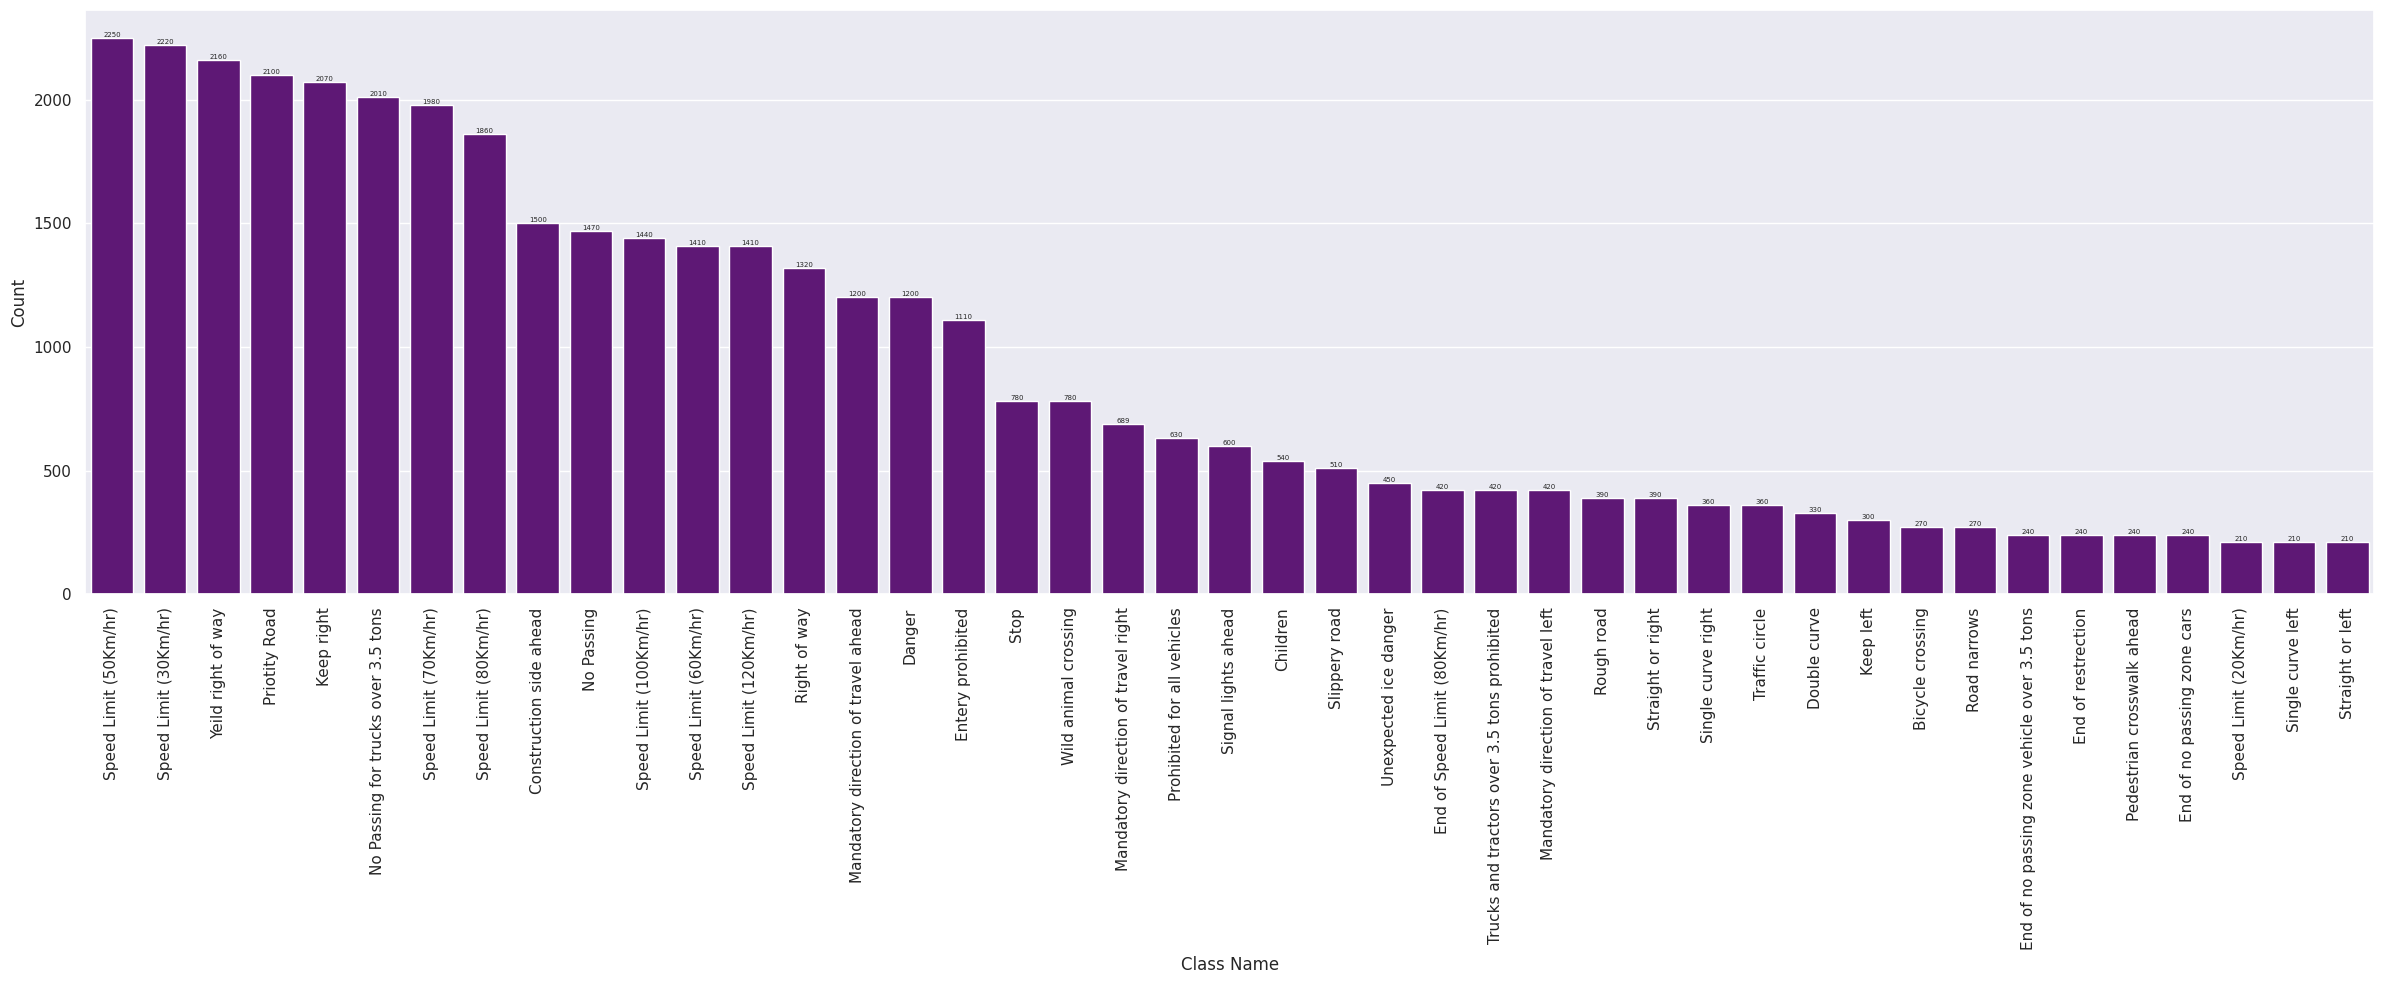

In [11]:
plt.figure(figsize=(24, 10))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#660885")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=5)
plt.savefig("./Results/figures/dataset.png", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [14]:
train_df["ClassId_str"] = train_df["ClassId"].astype(str)
train_df["ClassId"] = train_df["ClassId"].astype(int)
train_df["Path"] = train_df["Path"].str.replace("Train/", "")

train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

In [15]:
num_classes=len(train_df["ClassName"].unique())
num_classes

43

In [16]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

In [17]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    fill_mode='nearest'
    
)

train_gen_aug = train_datagen_aug.flow_from_dataframe(
    dataframe = train_data,
    directory=train_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 31367 validated image filenames belonging to 43 classes.


In [18]:
class_indices = train_gen_aug.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

In [19]:
valid_datagen_aug = ImageDataGenerator(rescale=1./255)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

valid_gen_aug = valid_datagen_aug.flow_from_dataframe(
    dataframe = valid_data,
    directory = train_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_df["ClassId_str"] = test_df["ClassId"].astype(str)
test_df["ClassId"] = test_df["ClassId"].astype(int)
test_df["Path"] = test_df["Path"].str.replace("Test/", "")

test_gen_aug = test_datagen_aug.flow_from_dataframe(
    dataframe = test_df,
    directory=test_imgs,
    x_col = "Path",
    y_col = "ClassId_str",
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 7842 validated image filenames belonging to 43 classes.


Found 12630 validated image filenames belonging to 43 classes.


In [20]:
class_weight = compute_class_weight('balanced', classes=np.unique(train_df['ClassId']),
                                  y=train_df['ClassId'])
class_weights_dict = dict(enumerate(class_weight))
class_weights_dict

{0: np.float64(4.342081949058693),
 1: np.float64(0.41073748166771423),
 2: np.float64(0.4052609819121447),
 3: np.float64(0.6466930562427841),
 4: np.float64(0.46052384308198263),
 5: np.float64(0.49023505876469115),
 6: np.float64(2.1710409745293466),
 7: np.float64(0.6332202842377261),
 8: np.float64(0.6466930562427841),
 9: np.float64(0.620297421294099),
 10: np.float64(0.45365035288672917),
 11: np.float64(0.6907857646229739),
 12: np.float64(0.4342081949058693),
 13: np.float64(0.4221468561584841),
 14: np.float64(1.1690220632081096),
 15: np.float64(1.447360649686231),
 16: np.float64(2.1710409745293466),
 17: np.float64(0.8214749633354285),
 18: np.float64(0.7598643410852713),
 19: np.float64(4.342081949058693),
 20: np.float64(2.5328811369509046),
 21: np.float64(2.7631430584918957),
 22: np.float64(2.3380441264162193),
 23: np.float64(1.7879160966712266),
 24: np.float64(3.3771748492678726),
 25: np.float64(0.6078914728682171),
 26: np.float64(1.5197286821705427),
 27: np.flo

In [21]:
train_gen_aug.class_indices == valid_gen_aug.class_indices 

True

CNN

In [22]:
cnn_model = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding="same"),
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax', dtype='float32')
])


/home/miislam/Fall25/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1764172707.659708 1723862 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35216 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:e1:00.0, compute capability: 9.0


In [23]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,763 (1.40 MB)

 Trainable params: 366,251 (1.40 MB)

 Non-trainable params: 512 (2.00 KB)

In [24]:
cnn_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy', 'precision', 'recall'])

In [25]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=10,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [26]:
history_aug = cnn_model.fit(
    train_gen_aug, 
    validation_data=valid_gen_aug, 
    epochs=50, 
    callbacks=callbacks)

Epoch 1/50


2025-11-26 15:58:31.598515: I external/local_xla/xla/service/service.cc:163] XLA service 0x7848d80193b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 15:58:31.598551: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA H100 NVL, Compute Capability 9.0
2025-11-26 15:58:31.699977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 15:58:32.102807: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-26 15:58:32.324491: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 15:58:32.324523: I external/

  1/981 ━━━━━━━━━━━━━━━━━━━━ 8:17:15 30s/step - accuracy: 0.0000e+00 - loss: 3.8313 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1764172739.759389 1727038 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/981 ━━━━━━━━━━━━━━━━━━━━ 1:38 230ms/step - accuracy: 0.1058 - loss: 3.3319 - precision: 0.4079 - recall: 0.0036

2025-11-26 16:01:07.385042: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2964', 8 bytes spill stores, 8 bytes spill loads



555/981 ━━━━━━━━━━━━━━━━━━━━ 1:52 265ms/step - accuracy: 0.1059 - loss: 3.3309 - precision: 0.4083 - recall: 0.0036

2025-11-26 16:01:26.337142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 8 bytes spill stores, 8 bytes spill loads



981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.1251 - loss: 3.2129 - precision: 0.4578 - recall: 0.0071

2025-11-26 16:03:05.228898: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 16:03:05.595086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 52 bytes spill stores, 52 bytes spill loads

2025-11-26 16:03:05.640599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 88 bytes spill stores, 88 bytes spill loads

2025-11-26 16:03:05.650060: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 84 bytes


Epoch 1: val_loss improved from None to 2.72305, saving model to CNN_best_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 301s 276ms/step - accuracy: 0.1624 - loss: 3.0008 - precision: 0.5642 - recall: 0.0164 - val_accuracy: 0.2179 - val_loss: 2.7230 - val_precision: 0.7216 - val_recall: 0.0519
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2313 - loss: 2.6651 - precision: 0.7166 - recall: 0.0564
Epoch 2: val_loss improved from 2.72305 to 2.43567, saving model to CNN_best_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 230s 234ms/step - accuracy: 0.2475 - loss: 2.5915 - precision: 0.7316 - recall: 0.0666 - val_accuracy: 0.2682 - val_loss: 2.4357 - val_precision: 0.7178 - val_recall: 0.0859
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.2890 - loss: 2.3369 - precision: 0.7585 - recall: 0.0949
Epoch 3: val_loss improved from 2.43567 to 1.92660, saving model to CNN_best_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 234s 239ms/step - accuracy: 0.3059 - loss: 2.2595 

In [27]:
test_loss, test_accuracy, test_precision, test_recall = cnn_model.evaluate(test_gen_aug)
print(f"Test accuracy : {test_accuracy*100:.2f}%")
print(f"Test loss : {test_loss:.3f}")

  1/395 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.7812 - loss: 0.8558 - precision: 0.8571 - recall: 0.7500

393/395 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7627 - loss: 0.8536 - precision: 0.8101 - recall: 0.7316

2025-11-26 18:19:29.862864: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 18:19:29.862896: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 18:19:30.004318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_255', 4 bytes spill stores, 4 bytes spill loads

2025-11-26 18:19:30.292170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

395/395 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7573 - loss: 0.8862 - precision: 0.8058 - recall: 0.7297
Test accuracy : 75.73%
Test loss : 0.886


In [28]:
results = cnn_model.evaluate(valid_gen_aug)
print(results)

  1/246 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9375 - loss: 0.1153 - precision: 1.0000 - recall: 0.9375

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9890 - loss: 0.0357 - precision: 0.9912 - recall: 0.9880
[0.03565869480371475, 0.9890334010124207, 0.9911730885505676, 0.9880132675170898]


In [29]:
idx_to_class = {v: k for k, v in train_gen_aug.class_indices.items()}
true_labels = test_gen_aug.classes  
pred_probs = cnn_model.predict(test_gen_aug)        
pred_labels = np.argmax(pred_probs, axis=1) 
target_names = list(test_gen_aug.class_indices.keys())
print(classification_report(true_labels, pred_labels, target_names=target_names))

report_dict = classification_report(
    true_labels,
    pred_labels,
    target_names=target_names,
    output_dict=True
)

df = pd.DataFrame(report_dict).transpose()

df.to_csv("./Results/csv/glare/classification_report_glare_left.csv", index=True)
print("Saved to classification_report.csv")

395/395 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step
              precision    recall  f1-score   support

           0       1.00      0.23      0.38        60
           1       0.65      0.63      0.64       720
          10       0.98      0.54      0.70       660
          11       0.92      0.91      0.91       420
          12       0.79      0.98      0.88       690
          13       0.89      0.97      0.93       720
          14       1.00      0.79      0.88       270
          15       0.73      0.63      0.68       210
          16       0.66      0.43      0.52       150
          17       0.90      0.84      0.87       360
          18       0.81      0.76      0.78       390
          19       0.96      0.40      0.56        60
           2       0.54      0.57      0.56       750
          20       0.86      0.88      0.87        90
          21       0.88      0.62      0.73        90
          22       1.00      0.68      0.81       120
          23       0.66      0.93     